# Model Selection

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
from tqdm.auto import tqdm
import matplotlib as mpl
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

Data (from maternity ward example used in the lecture):

In [3]:
y = np.array([ 7,  8,  3,  7, 11,  7,  9, 19,  7, 15,  9,  5, 12,  3,  7,  6,  5, 3, 11,  5])

## Compute Bayes factor

Simulate posteriors with SMC (sequential Monte Carlo). This algorithm (that wasn't introduced) computes the log-predictive density along the way, as introduced [here](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Bayes_factor.html).

In [4]:
with pm.Model() as maternity_ward_model:
    lbd = pm.Gamma( 'lbd', alpha=37.5, beta=2.5 )
    y_obs = pm.Poisson( 'y_obs', mu=lbd, observed=y )
    trace = pm.sample_smc( 1000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


In [5]:
with pm.Model() as maternity_ward_model2:
    lbd = pm.Gamma( 'lbd', alpha=37.5, beta=2.5 )
    alpha = pm.Gamma( 'alpha', alpha=2, beta=0.1 )
    y_obs = pm.NegativeBinomial( 'y_obs', mu=lbd, alpha=alpha, observed=y )
    trace2 = pm.sample_smc( 1000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Compute Bayes factor:

In [6]:
lpd1 = trace.sample_stats.log_marginal_likelihood.mean().values
lpd2 = trace2.sample_stats.log_marginal_likelihood.mean().values
BF = np.exp( lpd2 - lpd1 )
BF

18.7258056423024

## Expected Log Predictive Density (ELPD)

Compute log-likelihoods and leave-one-out (LOO) cross validation estimates:

In [7]:
with maternity_ward_model:
    pm.compute_log_likelihood(trace)
loo1 = pm.loo( trace )

In [8]:
with maternity_ward_model2:
    pm.compute_log_likelihood(trace2)
loo2 = pm.loo( trace2 )

Compare:

In [9]:
df_comp_loo = pm.compare({'Poisson Likelihood': loo1, 'Negative Binomial Likelihood': loo2})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Negative Binomial Likelihood,0,-56.768777,1.490704,0.000000,0.863394,3.010216,0.000000,False,log
Poisson Likelihood,1,-58.718103,1.667373,1.949326,0.136606,5.587756,2.584378,False,log


Plot:

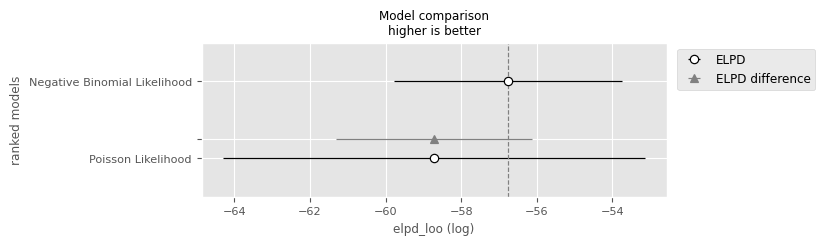

In [10]:
pm.plot_compare(df_comp_loo);

The computed ELPDs overlap strongly! By the one-standard-error rule, we should settle for the simpler Poisson model that only contains one parameter, even though the assumptions it makes are worse.

## Compute classical predictive metrics

Sample predictions:

In [11]:
with maternity_ward_model:
    ppc = pm.sample_posterior_predictive(trace)

with maternity_ward_model2:
    ppc2 = pm.sample_posterior_predictive(trace2)

Sampling: [y_obs]


Sampling: [y_obs]


Reshape predictions such that broadcasted difference with $y$ is possible:

In [12]:
ypred1 = ppc.posterior_predictive.y_obs.values.reshape(-1,20)
ypred2 = ppc2.posterior_predictive.y_obs.values.reshape(-1,20)
ypred1.shape, ypred2.shape

((4000, 20), (4000, 20))

Compute differences:

In [13]:
eps1 = ypred1-y
eps2 = ypred2-y

RMSE:

In [14]:
rmse1 = np.sqrt(np.mean( eps1**2 ))
rmse2 = np.sqrt(np.mean( eps2**2 ))
rmse1, rmse2

(5.059608433465973, 6.226900312354454)

MAE:

In [15]:
mae1 = np.mean( np.abs(eps1) )
mae2 = np.mean( np.abs(eps2) )
mae1, mae2

(3.9838125, 4.7997875)

The predictions of the Poisson model are closer to the data!